# Federated Learning Tutorial

Author: Daniyal Shahrokhian

## Problem

Worldline has open sourced some of their data of credit card transactions to
try to predict fraud:

https://www.kaggle.com/mlg-ulb/creditcardfraud

Imagine this dataset is cut in half horizontally. Alice has half of the data
and Bob has the other half. Neither of them wants to send their raw data to us.
However, we convince them to let our model learn from their data in a federated
setting. Implement a way for our model to train on the combined data of both
Alice and Bob without either of them sending us any raw data. Compare it with the model with the traditional approach that can see all the data at once.

## Dependencies & Setup

In [29]:
%%shell
pip install sklearn
pip install pandas
pip install matplotlib
pip install tensorflow

pip uninstall --yes tensorboard tb-nightly

pip install --quiet --upgrade tensorflow-federated
pip install --quiet --upgrade nest-asyncio
pip install --quiet --upgrade tensorboard
pip install tensorflow-federated

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Found existing installation: tensorboard 2.14.1
Uninstalling tensorboard-2.14.1:
  Successfully uninstalled tensorboard-2.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take int

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

import nest_asyncio
nest_asyncio.apply()

import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

SEED = 1337
tf.random.set_seed(SEED)

## Data

In [ ]:
!unzip /content/creditcard.csv.zip

Archive:  /content/creditcard.csv.zip
  inflating: creditcard.csv          


In [31]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [32]:
# Creating Alice and Bob's splits:
alice_df = df[:len(df.index)//2]
bob_df = df[len(df.index)//2:]

### Exploratory Analysis

Fraudulent transactions only account for 0.17% of the total transactions. Given the large distribution difference, class weighting applied to the classifier won't cut it, so it is very likely that we will need to rely on under/over-sampling.

In [33]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


When splitting the data horizontally, the class distribution does not change drastically.

In [34]:
alice_df['Class'].value_counts()

,count
Class,
0,142134
1,269


In [35]:
bob_df['Class'].value_counts()

,count
Class,
0,142181
1,223


As it can be seen by plotting the density estimation of the two datasets, there is some differences between the two. In many Federated scenarios, the data sources are non-i.i.d. (Independent and Identically Distributed). At first glance, this also happens in our dataset, but given the small variance it won't be much of a problem. The only variables that have significant differences are `Time` and `Amount`, the former we will not even include on our classifier.

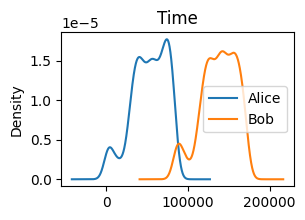

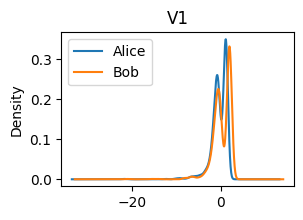

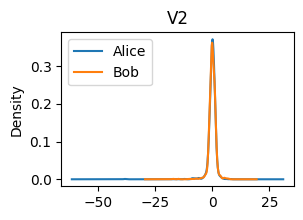

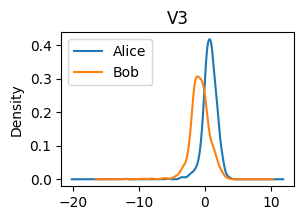

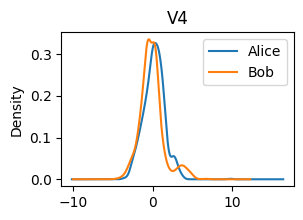

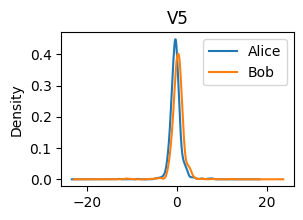

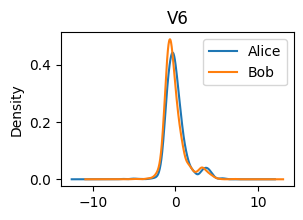

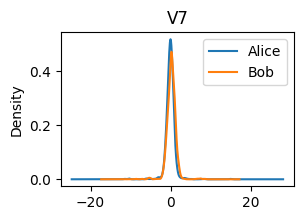

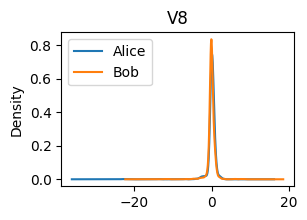

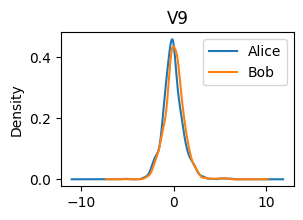

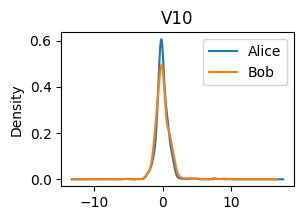

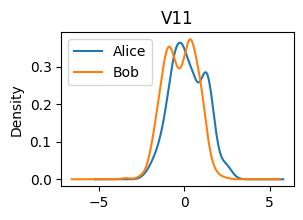

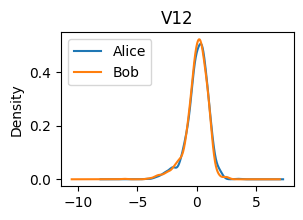

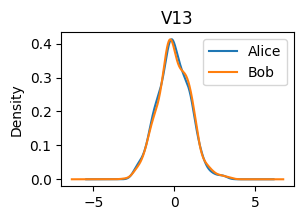

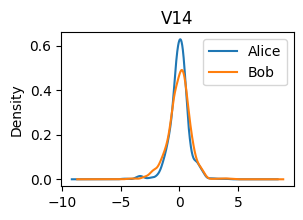

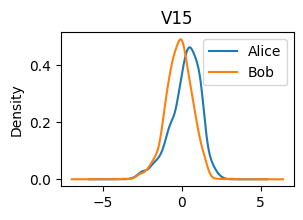

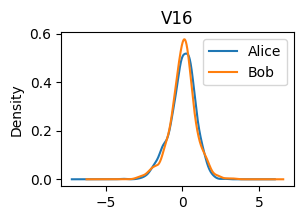

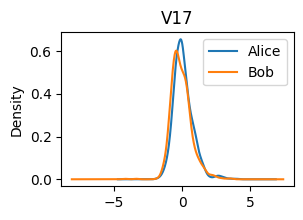

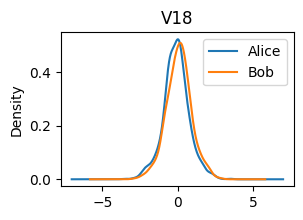

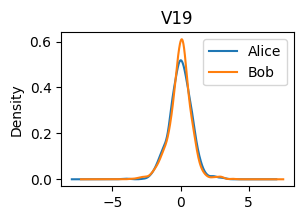

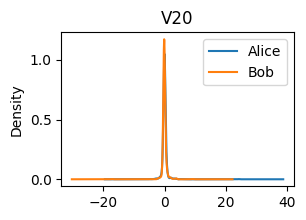

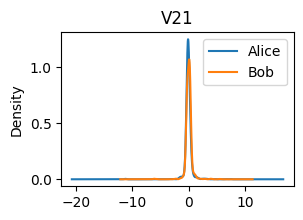

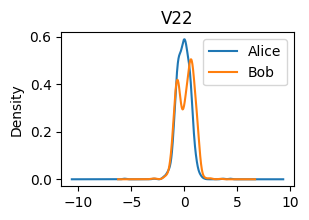

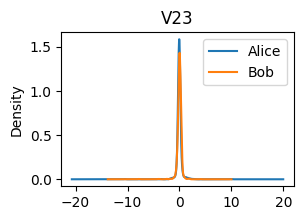

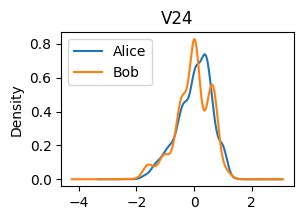

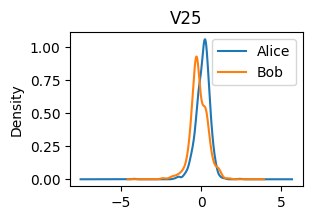

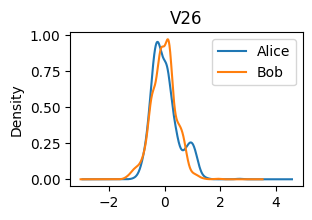

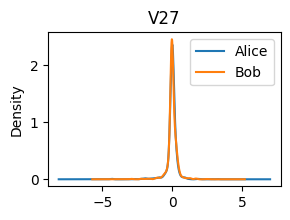

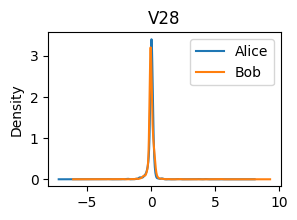

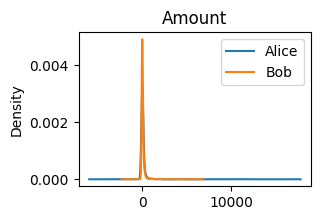

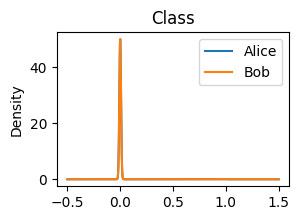

In [36]:
for col in df:
    combined = pd.concat([alice_df[col].reset_index(drop=True), bob_df[col].reset_index(drop=True)], axis=1, ignore_index=True, keys=['Alice', 'Bob'])
    fig, ax = plt.subplots(figsize=(3,2))
    combined.sample(1000, random_state=SEED).plot(kind='density', ax=ax) # Random sample of 1000 to ease computation
    ax.title.set_text(col)
    ax.legend(['Alice', 'Bob'])
    plt.show()

## Setup

In [37]:
EPOCHS = 100
BATCH_SIZE = 64

## Federated Learning Approach

### Data Loading

In [39]:
def make_tf_dataset(dataframe, negative_ratio=None, batch_size=None):
    dataset = dataframe.drop(['Time'], axis=1)

    # Class balancing
    pos_df = dataset[dataset['Class'] == 1]
    neg_df = dataset[dataset['Class'] == 0]
    if negative_ratio:
        neg_df = neg_df.iloc[random.sample(range(0, len(neg_df)), len(pos_df)*negative_ratio), :]
    balanced_df = pd.concat([pos_df, neg_df], ignore_index=True, sort=False)

    y = balanced_df.pop('Class')

    # Dataset creation
    dataset = tf.data.Dataset.from_tensor_slices((balanced_df.values, y.to_frame().values))
    dataset = dataset.shuffle(2048, seed=SEED)
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [40]:
train_data, val_data = [], []
for client_data in [alice_df, bob_df]:
    train_df, val_df = train_test_split(client_data, test_size=0.1, random_state=SEED)

    # Scaling (Standardization actually hurts performance)
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_df.drop(['Class'], axis=1))
    val_features = scaler.transform(val_df.drop(['Class'], axis=1))

    train_df[train_df.columns.difference(['Class'])] = train_features
    val_df[val_df.columns.difference(['Class'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, negative_ratio=10, batch_size=BATCH_SIZE))
    val_data.append(make_tf_dataset(val_df, batch_size=1))

### Model Definition

In [41]:
def input_spec():
    return (
        tf.TensorSpec([None, 29], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(29,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.models.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[BinaryAccuracy(), Precision(), Recall()])

### Training

Each time the `next` method is called, the server model is broadcast to each client using a broadcast function. For each client, one epoch of local training is performed. Each client computes the difference between the client model after training and the initial broadcast model. These model deltas are then aggregated at the server using some aggregation function.

In [ ]:
#!pip uninstall -y tensorflow-federated
#!pip install tensorflow-federated

Found existing installation: tensorflow_federated 0.86.0
Uninstalling tensorflow_federated-0.86.0:
  Successfully uninstalled tensorflow_federated-0.86.0
  Using cached tensorflow_federated-0.86.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
Using cached tensorflow_federated-0.86.0-py3-none-manylinux_2_31_x86_64.whl (71.9 MB)


In [42]:
import tensorflow_federated as tff

#trainer = tff.learning.build_federated_averaging_process(
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam()
)


state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")

Run 100/100

In [72]:
#!pip install --force-reinstall tensorflow-federated

  Using cached tensorflow_federated-0.86.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached dm_tree-0.1.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached dp_accounting-0.4.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached google_vizier-0.1.11-py3-none-any.whl.metadata (10 kB)
  Using cached jaxlib-0.4.14-cp310-cp310-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached jax-0.4.14-py3-none-any.whl
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached portpicker-1.6.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached scipy-1.9.3-cp310-cp310-manylinux_2_17_x86_64

### Evaluation

In [43]:

#evaluator = tff.learning.build_federated_evaluation(model_fn)
evaluator = tff.learning.algorithms.build_fed_eval(model_fn)

In [54]:
#federated_metrics = evaluator(state.model, val_data)
#val_data = [val_data]
federated_metrics = evaluator.next(state.global_model_weights,[val_data])


TypeError: Cannot serialize a struct value of 2 elements to a struct type requiring 5 elements. Trying to serialize
ModelWeights(trainable=[array([[-1.45190107e-02,  2.24748090e-01, -6.98294640e-02,
        -1.49314076e-01, -1.81567758e-01, -6.67991638e-02,
         8.22161436e-02,  1.21462651e-01,  2.65491009e-01,
         2.55732924e-01, -2.45341897e-01,  1.87968209e-01,
        -2.21276581e-02,  7.61740282e-02, -1.85153395e-01,
        -1.39502019e-01,  1.75843686e-01,  1.91577747e-01,
        -1.27456158e-01,  9.45433080e-02, -3.03135574e-01,
        -3.52958739e-02, -1.59973666e-01,  4.42544837e-03,
        -1.77916363e-01,  5.61464019e-02, -2.45056584e-01,
         2.59987302e-02, -2.77126104e-01,  1.93912894e-01,
        -1.34174109e-01, -2.38080338e-01],
       [-2.66035106e-02,  2.77859986e-01, -2.50005841e-01,
        -1.05106145e-01,  2.55620945e-02, -3.64037454e-02,
        -3.04801941e-01,  1.15821473e-01,  2.16972083e-01,
         1.72492892e-01, -1.36158213e-01, -2.15586066e-01,
         2.96856165e-01, -1.31429434e-02,  1.71828091e-01,
        -2.11189732e-01,  1.16180941e-01,  8.88968557e-02,
         6.60418570e-02, -7.18829632e-02,  1.38563752e-01,
         1.73213989e-01,  1.50156707e-01, -6.58962727e-02,
         1.77190542e-01, -1.60908159e-02,  1.34602198e-02,
         1.44222274e-01, -1.47806138e-01, -7.89349526e-02,
        -1.26044214e-01, -2.56416023e-01],
       [ 2.58848488e-01, -4.34538387e-02,  2.17306390e-01,
         6.14303388e-02,  1.69032544e-01,  1.17140025e-01,
         2.13006675e-01, -4.74475659e-02,  2.71007538e-01,
        -6.58094734e-02,  1.73810586e-01, -7.76986033e-02,
        -2.78598338e-01,  1.10321678e-01,  2.40746364e-02,
         8.98353308e-02,  1.77620351e-01, -2.85641611e-01,
        -2.42512912e-01, -1.43712819e-01,  2.79348493e-01,
        -1.51776075e-01,  5.43268993e-02,  1.36684775e-01,
         2.52602220e-01, -2.82782800e-02,  2.01512545e-01,
        -1.35364890e-01, -2.41467118e-01,  1.14703447e-01,
        -1.51017070e-01, -2.64207721e-01],
       [-1.76709741e-01,  1.75986350e-01,  8.49249661e-02,
         2.10465938e-01,  7.37278759e-02,  2.00391352e-01,
         2.98621774e-01,  1.99407279e-01, -1.30173475e-01,
        -1.10887639e-01,  2.72884279e-01,  1.90456747e-03,
         3.01700532e-02,  6.73702173e-03,  9.05691832e-02,
         5.84781654e-02,  3.19164753e-01, -2.30038330e-01,
         1.76268876e-01,  8.70166440e-03, -5.12694120e-02,
        -1.02019466e-01,  1.89275101e-01, -1.43005073e-01,
         1.19115561e-01, -1.84757650e-01,  2.54492730e-01,
        -1.66880697e-01,  2.38367915e-01, -1.92222983e-01,
         2.46380910e-01, -5.03395014e-02],
       [ 2.19992340e-01,  2.32090876e-01,  3.26274455e-01,
        -5.97288534e-02,  1.33928716e-01,  8.73259902e-02,
        -1.08903527e-01,  2.46497631e-01,  3.34903866e-01,
        -5.32878153e-02,  6.09227922e-03, -2.24786744e-01,
         2.17077076e-01,  1.31630391e-01,  1.64740086e-01,
        -2.01433390e-01, -1.66751713e-01, -3.07036817e-01,
         2.04911470e-01, -2.33754024e-01, -1.61956295e-01,
        -1.58129245e-01,  2.00027406e-01,  1.29669428e-01,
         1.61749721e-02,  6.53212294e-02, -1.70499980e-01,
         1.44695401e-01, -3.12089175e-01,  2.03656554e-01,
         2.91332483e-01,  2.65194803e-01],
       [-4.87187319e-03, -1.18523762e-02, -1.44850403e-01,
         2.39825085e-01, -1.44921809e-01,  4.67976332e-02,
        -1.70652002e-01, -2.69747645e-01,  1.24762226e-02,
         3.38506609e-01,  3.09476972e-01,  1.52614534e-01,
        -1.82110742e-01, -1.00375980e-01,  4.23224084e-02,
        -3.85408811e-02,  1.07054345e-01, -1.00618072e-01,
        -2.23182440e-02, -2.36659333e-01, -8.56126845e-02,
         2.04386532e-01,  3.59941907e-02,  5.47709018e-02,
        -2.53446698e-02,  1.66237041e-01, -9.93491411e-02,
         1.41850859e-01,  1.92623675e-01, -1.20837234e-01,
        -8.59988555e-02, -2.53229260e-01],
       [ 2.90934265e-01,  1.50691301e-01,  1.15282744e-01,
         2.14119926e-01,  8.35028850e-03, -3.12531918e-01,
        -9.01703089e-02,  3.03715050e-01,  8.59116390e-02,
         2.02467352e-01,  3.49699259e-01, -3.26114669e-02,
        -3.99904251e-02, -1.22446865e-01, -1.58110425e-01,
         1.90696269e-01, -1.89561456e-01, -2.47020513e-01,
        -2.46303946e-01,  1.79414898e-01,  1.24376953e-01,
         1.03603765e-01, -1.75988793e-01,  2.18824655e-01,
         3.00809085e-01,  7.08830431e-02, -1.50535583e-01,
        -2.86533624e-01, -1.58366695e-01, -2.45262563e-01,
         7.83457384e-02, -1.79105937e-01],
       [ 1.64783522e-02,  2.31328443e-01,  3.28295417e-02,
         2.16693312e-01, -2.72290379e-01, -2.81411797e-01,
         2.56971419e-02, -2.19970137e-01,  1.41740903e-01,
         2.51920000e-02,  2.82585621e-01, -1.78610027e-01,
        -2.46823788e-01,  8.95951018e-02, -9.00428742e-02,
         1.15972795e-01,  3.10109332e-02,  1.24927670e-01,
        -9.53606665e-02, -6.25158697e-02, -2.08202094e-01,
        -7.04247132e-02, -9.70205143e-02,  2.78724581e-01,
        -6.34699166e-02,  1.79367945e-01,  1.55425921e-01,
        -1.42532527e-01,  3.83696854e-02, -5.71959168e-02,
        -2.38508373e-01,  3.09133381e-01],
       [ 7.99782649e-02,  6.62941486e-02, -1.55055329e-01,
        -1.84947297e-01, -9.15533006e-02, -8.13579559e-03,
        -2.55972326e-01, -1.99252777e-02, -3.38933527e-01,
         3.84104878e-01, -2.25462213e-01, -1.79245755e-01,
        -3.54149938e-02, -7.06472099e-02, -1.85638070e-01,
         1.58452302e-01,  6.16711676e-02, -3.18785369e-01,
         5.05226552e-02, -4.60262485e-02,  2.90702879e-02,
        -9.88243893e-02, -1.23641230e-01,  2.21141934e-01,
         2.02907562e-01, -2.06903413e-01,  1.93082407e-01,
        -2.95169085e-01,  2.94155657e-01,  1.11245193e-01,
        -1.46353006e-01, -1.17007665e-01],
       [-8.65678070e-04,  2.74177402e-01, -2.90230334e-01,
        -1.71300754e-01,  3.53764504e-01, -2.58499742e-01,
        -8.31977725e-02,  8.57040733e-02,  2.87603706e-01,
        -1.24574080e-01,  1.33685127e-01,  1.15388788e-01,
        -1.19474858e-01, -1.55971106e-02, -2.53160417e-01,
         2.00571179e-01, -1.89258888e-01, -4.63791192e-02,
        -1.74537852e-01,  4.11273651e-02, -9.40384418e-02,
         8.17783102e-02,  6.95531666e-02,  2.49838427e-01,
        -3.04798186e-01, -8.49045366e-02, -1.87767074e-01,
         1.52812079e-01, -6.49888068e-02,  5.30530885e-02,
         9.46718827e-02, -1.67614110e-02],
       [ 1.91843554e-01,  5.57449386e-02, -6.62338957e-02,
         2.20788598e-01,  9.75620188e-03,  8.91472399e-02,
         1.03001535e-01, -3.70452404e-01,  1.68142542e-01,
         1.12381838e-02,  1.20700784e-01,  1.04668982e-01,
        -2.23671272e-01,  2.35583007e-01,  7.94170499e-02,
         2.66719192e-01,  1.19887799e-01, -1.75179750e-01,
         1.09281510e-01,  1.12518698e-01, -1.88501984e-01,
         6.40032366e-02, -6.96106777e-02,  7.88795725e-02,
        -1.40947640e-01,  1.45435125e-01, -9.83490720e-02,
        -1.85774699e-01, -2.17081279e-01, -3.83380502e-01,
         7.63140619e-02, -3.53320897e-01],
       [-9.28385183e-02, -1.04687735e-02, -1.84433475e-01,
         3.21979113e-02, -4.22632955e-02,  2.18852997e-01,
        -2.44844362e-01,  1.95753902e-01,  3.66433375e-02,
        -1.45513177e-01, -1.91061243e-01, -2.41470337e-01,
        -2.30858028e-01, -1.31609559e-01, -8.05365201e-03,
        -4.02479433e-02, -1.52481407e-01,  2.41843730e-01,
        -5.05298972e-02, -2.41612233e-02, -2.74003923e-01,
         2.15582531e-02,  2.49075055e-01, -5.23523102e-03,
         1.56466395e-01,  3.09296519e-01,  1.15779333e-01,
         2.56701112e-01,  7.58089125e-02, -2.17616156e-01,
         1.62202795e-03,  2.94281840e-01],
       [-1.32352993e-01, -2.04856647e-03, -1.52181104e-01,
        -2.66553223e-01, -6.09835535e-02, -1.92871392e-01,
        -5.93726039e-02,  1.03575245e-01, -6.93675727e-02,
         5.83282411e-02,  3.14029098e-01, -1.28959730e-01,
        -1.33834749e-01,  2.06590712e-01,  3.14295180e-02,
         1.36496630e-02, -2.57664174e-01,  2.27100760e-01,
        -1.72664016e-01, -2.68789589e-01, -2.41508096e-01,
        -1.95892647e-01, -3.10268492e-01, -2.29935467e-01,
        -2.78845310e-01, -2.59123802e-01, -5.51440865e-02,
         6.18109703e-02, -1.79690838e-01,  2.94509441e-01,
        -2.44105890e-01,  1.53266430e-01],
       [ 3.32515031e-01,  6.26783725e-03,  1.70400888e-01,
        -1.00934930e-01,  2.55231798e-01, -6.33500516e-02,
         1.86954618e-01, -9.66910198e-02, -2.58884579e-01,
         1.62786618e-01, -7.18342513e-02, -4.20175157e-02,
        -1.22984067e-01, -2.42367104e-01,  2.45666370e-01,
        -1.98104586e-02,  1.98526338e-01, -2.80206054e-01,
        -1.83291867e-01, -2.19409287e-01, -3.70949507e-02,
        -3.11920434e-01,  1.95872471e-01, -2.75469720e-01,
         2.74565399e-01,  1.48948997e-01,  9.92380679e-02,
         2.84377456e-01, -1.40119582e-01, -2.49146700e-01,
         1.06969448e-02,  2.62698889e-01],
       [-1.78832144e-01, -3.14908117e-01,  5.15885018e-02,
         2.76910394e-01,  2.67037213e-01, -2.59960920e-01,
         1.36632413e-01, -7.50541836e-02, -1.85252160e-01,
        -1.84431866e-01,  9.71197486e-02, -1.39579356e-01,
        -1.66443259e-01,  1.88698694e-01,  6.97627068e-02,
         3.31361853e-02, -1.32717276e-02,  1.12197816e-01,
        -2.71206796e-02, -2.85457134e-01,  1.98414624e-01,
         8.41338262e-02, -2.16956437e-01,  2.29739010e-01,
        -5.66729009e-02,  2.67663337e-02,  1.61834940e-01,
        -2.15216503e-02, -4.68344092e-02, -8.32266361e-02,
        -4.56033554e-03, -2.35407948e-01],
       [ 3.19903255e-01,  4.08398509e-02,  9.04267505e-02,
        -1.54547676e-01,  8.64010155e-02,  1.62878036e-01,
        -8.28081369e-02,  1.91192031e-01,  1.40015319e-01,
         2.17670456e-01,  2.93200016e-01,  1.69447780e-01,
        -1.16094247e-01,  3.79079878e-02, -2.97616243e-01,
         9.51117501e-02,  3.12651455e-01, -1.12011336e-01,
        -9.48743373e-02, -2.28565335e-01, -2.79953539e-01,
        -3.06992203e-01, -2.02426627e-01,  4.32880260e-02,
        -1.99649811e-01, -2.69747019e-01,  3.01721096e-01,
         1.64785996e-01,  5.18602133e-02, -6.41756058e-02,
        -1.57160256e-02, -2.08523929e-01],
       [-2.24920273e-01,  5.66020235e-02, -2.03576669e-01,
        -1.94002062e-01,  1.90323472e-01,  2.26318061e-01,
        -2.48897567e-01,  1.62856728e-01,  1.68761417e-01,
         2.04580724e-01,  1.06808990e-01, -1.66847825e-01,
        -2.69337058e-01, -1.27953619e-01,  8.36388767e-03,
        -1.84900016e-01,  3.39262426e-01, -1.86059594e-01,
         1.76676214e-02, -8.78655612e-02, -2.74783373e-01,
         4.66976054e-02,  2.71311164e-01,  1.30660478e-02,
        -2.91869611e-01,  1.83454335e-01,  3.15487117e-01,
         1.48474023e-01, -6.54127002e-02, -7.20394850e-02,
         9.76696089e-02,  2.70996869e-01],
       [ 1.87906116e-01, -9.49670672e-02,  3.50192189e-01,
         1.03963844e-01, -1.73344210e-01, -1.43890068e-01,
         1.40253365e-01,  9.19544920e-02,  4.37147506e-02,
         3.23377490e-01,  2.52453595e-01,  2.30954471e-03,
         1.67745590e-01,  2.36421496e-01,  7.62932971e-02,
         3.17613602e-01, -3.33620869e-02,  9.68935192e-02,
         6.20878637e-02,  5.19697219e-02,  1.29162729e-01,
        -4.58283462e-02, -3.60810012e-01,  9.22083035e-02,
        -7.63056278e-02,  2.25574732e-01, -2.20382269e-02,
        -1.78195044e-01, -1.08515739e-01,  1.96774974e-01,
         2.31244743e-01,  1.14904620e-01],
       [ 2.46275410e-01, -4.37820442e-02, -1.49425954e-01,
        -3.80344987e-01,  3.55590910e-01, -7.59300590e-03,
        -7.41613358e-02,  1.47281423e-01, -5.03879078e-02,
        -1.94364995e-01,  1.62967905e-01, -1.11821428e-01,
        -1.29647106e-01, -1.19448110e-01, -9.49885324e-02,
         2.66024414e-02,  2.14363888e-01,  2.07906589e-02,
         1.99975014e-01, -1.82652727e-01,  1.20544434e-01,
         7.24778175e-02,  2.23528579e-01,  2.51058400e-01,
         1.71674609e-01,  9.66181105e-05,  2.74701029e-01,
         2.64259338e-01, -1.16251200e-01, -5.18091395e-03,
         2.11370036e-01,  1.89123973e-01],
       [ 7.19563141e-02,  2.66321927e-01, -8.83141011e-02,
         2.03150705e-01,  2.68604964e-01,  2.25516021e-01,
         1.16912723e-01,  2.14293718e-01,  2.52900720e-01,
        -1.72474459e-01, -3.35376233e-01, -1.28617048e-01,
        -1.59910485e-01,  7.08164796e-02, -8.70700404e-02,
        -1.27827704e-01,  1.32175431e-01,  3.15895438e-01,
        -1.01226628e-01,  1.58041686e-01,  7.49394298e-03,
         2.17588514e-01,  6.64778650e-02,  1.45875558e-01,
        -7.32324123e-02, -2.93122768e-01,  2.32411548e-01,
         1.41037866e-01,  1.75673515e-01,  2.17959985e-01,
         1.78659484e-01,  2.13212892e-01],
       [ 3.11121076e-01,  6.90019503e-02,  3.18924278e-01,
         9.75367147e-03,  1.87977180e-01, -2.50060081e-01,
         2.57032216e-01,  2.58238792e-01, -6.44261390e-02,
         4.29038778e-02, -8.95099416e-02, -2.70739466e-01,
         1.55240536e-01,  2.53920615e-01, -9.82204229e-02,
         2.68980891e-01, -2.14600846e-01,  1.90169185e-01,
        -1.60734713e-01, -2.01577902e-01,  1.55248761e-01,
        -3.17988098e-01,  6.62405565e-02,  1.05843477e-01,
        -1.14203885e-01,  8.99432302e-02,  1.21319212e-01,
         1.36137396e-01,  1.76262558e-02,  1.47076249e-01,
         3.29643637e-01,  1.87964484e-01],
       [ 1.97912261e-01,  1.54596955e-01, -5.39261363e-02,
         1.20356485e-01,  1.10984512e-01, -1.56006530e-01,
        -1.65850237e-01, -2.09148616e-01,  2.42961705e-01,
        -1.58354059e-01, -1.12165205e-01,  5.41351736e-02,
        -1.57832518e-01, -2.72875160e-01, -2.43422553e-01,
         3.74581367e-02,  6.85544461e-02,  1.22411467e-01,
         7.10730851e-02, -4.02755514e-02, -1.18173331e-01,
        -5.39743789e-02, -1.27998572e-02,  2.39761263e-01,
         2.56077766e-01, -5.48918135e-02, -1.95471451e-01,
        -2.45818987e-01,  3.06605697e-02,  3.59480053e-01,
        -1.37312457e-01, -2.28663266e-01],
       [-2.27271885e-01, -3.43036614e-02, -8.89787376e-02,
        -5.54592051e-02, -3.47767659e-02, -1.44398227e-01,
        -9.61531252e-02,  3.29339325e-01,  4.03560400e-02,
         8.94913524e-02,  1.83054432e-01,  1.16685718e-01,
         2.60238111e-01,  1.37314508e-02,  7.38934949e-02,
        -9.84267369e-02,  1.16987333e-01,  1.57135561e-01,
        -1.29004136e-01,  1.94668964e-01,  1.73158944e-01,
        -2.05695882e-01,  2.98796803e-01,  5.67778051e-02,
        -1.34709388e-01,  1.42783523e-01, -3.59062143e-02,
         2.66181737e-01, -1.03236020e-01,  2.63536602e-01,
         3.25745136e-01,  2.74980485e-01],
       [ 2.10013017e-01, -4.25738543e-02,  2.01139405e-01,
         1.33837536e-01,  2.19524905e-01, -1.86675400e-01,
         1.48184717e-01, -1.46568403e-01,  1.90049738e-01,
        -2.86091007e-02, -1.23326883e-01,  2.09967926e-01,
        -2.57527471e-01, -1.08755454e-02, -2.51721255e-02,
        -4.06584404e-02,  2.36929521e-01, -1.01458266e-01,
        -1.55442804e-01, -9.23014134e-02,  2.38107026e-01,
         2.44952574e-01, -2.54542492e-02,  1.53658018e-02,
        -2.29387149e-01, -8.58745351e-02, -6.97459728e-02,
         2.73179740e-01, -3.12513083e-01,  1.55106097e-01,
        -1.48954555e-01, -7.46141449e-02],
       [ 8.91669318e-02, -5.38053624e-02,  2.46001065e-01,
        -1.96503043e-01,  1.26654178e-01,  1.69884801e-01,
        -2.41443038e-01, -6.48403913e-02,  2.86311567e-01,
         1.62393942e-01,  1.80548117e-01,  2.69690696e-02,
        -2.00526774e-01, -2.96047628e-01,  2.40889221e-01,
         2.34134525e-01, -2.25966528e-01,  5.42088486e-02,
        -3.72948349e-02, -2.20479771e-01, -2.00417638e-03,
        -2.57890970e-01, -2.15651505e-02, -1.39031529e-01,
        -2.35785782e-01,  8.51520747e-02,  2.86121398e-01,
        -1.10573903e-01, -5.36179245e-02,  8.00616201e-03,
        -2.72658437e-01,  3.48836780e-02],
       [ 2.30000496e-01, -3.03526819e-01,  3.47490907e-01,
         7.85613656e-02,  4.53948677e-02, -1.82459116e-01,
        -1.12807930e-01,  8.64990354e-02,  3.01522017e-01,
        -6.33236691e-02, -4.14463021e-02,  4.62509505e-02,
        -8.53532851e-02, -4.57148142e-02,  3.34423512e-01,
        -8.96228384e-03,  2.61146545e-01, -2.95160800e-01,
         1.97900653e-01, -8.91075656e-02,  5.25644422e-02,
        -1.51547343e-01, -9.41184238e-02, -9.09945592e-02,
        -2.28696093e-01,  1.67623907e-01,  1.89038560e-01,
        -2.26466984e-01,  3.20382714e-02,  2.90400144e-02,
        -2.35268205e-01,  6.86276481e-02],
       [ 1.49807811e-01,  4.19231057e-02,  1.72885224e-01,
         1.07106216e-01, -2.11928114e-01,  5.09291887e-04,
        -8.24238658e-02,  1.79613024e-01, -3.54879722e-02,
         2.11877078e-01, -6.09395020e-02,  1.58518508e-01,
         2.26035237e-01,  2.33749136e-01,  2.45974287e-01,
         1.05472423e-01, -3.74545529e-02,  1.10032260e-01,
         1.76838487e-01, -1.63860023e-02, -2.36583114e-01,
         1.88605666e-01, -2.85929918e-01, -1.39827088e-01,
         1.68579638e-01, -2.30861962e-01,  2.72891998e-01,
         2.03961402e-01, -6.19190335e-02,  6.46675676e-02,
        -9.93000269e-02,  1.76224157e-01],
       [ 2.19634667e-01, -2.45570228e-01,  1.39679119e-01,
         2.83768475e-01, -3.03669274e-01, -1.11427218e-01,
        -1.93084657e-01, -5.66906929e-02, -4.92668375e-02,
         1.47423387e-01, -1.82202205e-01, -1.12427406e-01,
        -1.08183026e-02, -6.17676377e-02, -2.54320651e-02,
        -1.18049957e-01, -1.83256999e-01,  1.67478114e-01,
         6.87337220e-02,  2.54476458e-01,  7.25441277e-02,
         1.17138565e-01,  4.79661413e-02, -3.15956980e-01,
         1.73914373e-01,  6.57690987e-02, -1.30733296e-01,
         3.20380837e-01, -8.88551772e-02, -2.17986137e-01,
         2.34261796e-01,  3.20994854e-02],
       [ 1.89478219e-01, -2.83634573e-01,  3.55543271e-02,
         9.56031457e-02, -2.26386085e-01,  6.69527054e-03,
        -9.88945663e-02, -1.92523256e-01,  6.73506856e-02,
         7.27202222e-02, -1.74967900e-01, -1.01009138e-01,
        -1.20404065e-01,  2.29214758e-01,  6.87981397e-02,
        -1.80983990e-01,  1.02330148e-01,  2.25753069e-01,
        -9.29740071e-03, -1.13644198e-01,  1.06319785e-01,
        -4.53733690e-02,  2.67914414e-01,  6.38859393e-03,
         1.70801848e-01, -1.28594801e-01, -2.57592350e-01,
         2.46262744e-01, -2.32929349e-01, -2.51274943e-01,
         1.37973651e-01,  1.60849616e-01]], dtype=float32), array([ 0.0514323 , -0.03022325,  0.05661229,  0.0258171 , -0.0147235 ,
        0.        ,  0.        ,  0.00063339,  0.03038304,  0.04901643,
        0.04546542, -0.01166156,  0.        , -0.01594973,  0.04800566,
        0.05169622,  0.0084055 , -0.03500295,  0.        , -0.01433583,
        0.        , -0.03011428, -0.03623264, -0.02310465,  0.        ,
        0.05398052,  0.00562231,  0.00996277,  0.        ,  0.03302883,
        0.00864153,  0.03424492], dtype=float32), array([[ 0.09973654, -0.03831508,  0.04183475, ...,  0.13375762,
        -0.06901339, -0.17784625],
       [ 0.17962922, -0.06760335, -0.07366759, ..., -0.01981804,
        -0.06370458, -0.15210606],
       [ 0.19443193, -0.14610656,  0.13680372, ...,  0.08433101,
        -0.25808373, -0.18390079],
       ...,
       [ 0.15345293,  0.18981509,  0.24907666, ..., -0.15847181,
        -0.09845936, -0.01299881],
       [ 0.11212701,  0.19483349, -0.04730597, ...,  0.17349274,
        -0.16424136,  0.11354239],
       [-0.22111653, -0.12646985,  0.0182271 , ..., -0.12583895,
         0.00266785, -0.21225518]], dtype=float32), array([-1.80636365e-02,  6.39488101e-02, -6.62495615e-03,  1.51976803e-02,
        9.19466373e-03,  5.59511334e-02,  4.47499789e-02,  1.54545177e-02,
        4.11792062e-02,  2.66755186e-02,  0.00000000e+00,  5.58842486e-03,
        4.50495183e-02, -6.00261660e-03,  0.00000000e+00,  0.00000000e+00,
        6.13531545e-02,  0.00000000e+00, -2.45952792e-02, -2.86052912e-03,
        1.35196112e-02,  4.92295772e-02, -1.89776625e-02,  3.81917283e-02,
       -1.08069265e-02,  0.00000000e+00,  0.00000000e+00,  9.28608279e-05,
        1.11345015e-02,  0.00000000e+00,  4.80650142e-02,  2.83503905e-03,
        4.45235111e-02,  5.40522113e-02,  6.91430941e-02,  6.59131035e-02,
        1.60823427e-02,  5.18908948e-02,  5.77115454e-02, -1.71780251e-02,
       -1.85257532e-02,  4.67699654e-02,  2.63862237e-02,  1.10196145e-02,
       -1.55281518e-02,  8.55442882e-03,  5.90244420e-02,  0.00000000e+00,
       -4.19737734e-02,  6.24907427e-02,  1.20711606e-03, -6.29755156e-03,
        0.00000000e+00,  9.76262614e-04,  0.00000000e+00,  0.00000000e+00,
        1.40763316e-02,  5.24562635e-02,  0.00000000e+00,  4.75267097e-02,
       -8.46235827e-03, -9.58218239e-03, -5.06183021e-02, -2.76757237e-02],
      dtype=float32), array([[ 0.0676403 , -0.03105384, -0.14248389, ..., -0.15314496,
        -0.21225709,  0.1593469 ],
       [ 0.11995534,  0.05139126,  0.13728786, ...,  0.22784123,
         0.01633203,  0.21698831],
       [ 0.10655141,  0.03880693,  0.11246342, ...,  0.08271076,
        -0.20412302,  0.13875757],
       ...,
       [ 0.2446037 , -0.07208189, -0.01159377, ...,  0.25251037,
        -0.15038586,  0.23582697],
       [ 0.02756956,  0.07068218,  0.14289846, ..., -0.14718492,
        -0.02184159,  0.01861269],
       [ 0.13773641,  0.24978298,  0.14514312, ..., -0.07563889,
         0.23821205, -0.1898038 ]], dtype=float32), array([-0.01869667,  0.03980562,  0.0779072 , -0.01934556,  0.06013437,
        0.        ,  0.0274157 , -0.01888294,  0.0162232 , -0.01550887,
        0.07645052, -0.01058414,  0.01786513,  0.07626296,  0.05333408,
        0.03850899,  0.02010546,  0.0228058 , -0.01879247,  0.02050362,
       -0.06666415,  0.04068017,  0.05463503,  0.01657404,  0.01775642,
        0.05298741,  0.01734947,  0.04878357, -0.01728751,  0.06422125,
        0.        ,  0.05706454], dtype=float32), array([[ 0.22239366],
       [ 0.5038425 ],
       [ 0.19250157],
       [ 0.3722571 ],
       [ 0.36894545],
       [ 0.34946096],
       [-0.08424045],
       [-0.37085563],
       [-0.10969439],
       [-0.33244762],
       [ 0.47566172],
       [ 0.11060237],
       [-0.42350388],
       [ 0.16720717],
       [ 0.11256389],
       [ 0.1672764 ],
       [-0.4277167 ],
       [-0.36935163],
       [ 0.18435559],
       [ 0.49570885],
       [-0.21965033],
       [-0.14060281],
       [ 0.38339227],
       [-0.10881165],
       [-0.40716112],
       [ 0.40414643],
       [-0.21369971],
       [ 0.23517992],
       [ 0.0546127 ],
       [ 0.3198901 ],
       [-0.33740893],
       [ 0.44267833]], dtype=float32), array([-0.01808958], dtype=float32)], non_trainable=[])
to
<global_model_weights=<trainable=<float32[29,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,distributor=<>,client_work=<<>,<binary_accuracy=<float32,float32>,precision=<float32[1],float32[1]>,recall=<float32[1],float32[1]>,loss=<float32,float32>,num_examples=<int64>,num_batches=<int64>>>,aggregator=<value_sum_process=<>,weight_sum_process=<>>,finalizer=<>>.

## Single Model with all Data at once (for comparison)

### Data Loading

In [21]:
train_data = train_data[0].concatenate(train_data[1])
val_data = val_data[0].concatenate(val_data[1])

### Model Definition

In [22]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(29,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[BinaryAccuracy(), Precision(), Recall()],
    )

    return model

### Training

In [23]:
model = model_fn()
history = model.fit(train_data, epochs=EPOCHS)

Epoch 1/100
78/78 [==============================] - 2s 4ms/step - loss: 0.3241 - binary_accuracy: 0.8938 - precision: 0.2000 - recall: 0.0561
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.1492 - binary_accuracy: 0.9499 - precision: 1.0000 - recall: 0.4484
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0889 - binary_accuracy: 0.9766 - precision: 0.9940 - recall: 0.7466
Epoch 4/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0747 - binary_accuracy: 0.9823 - precision: 0.9945 - recall: 0.8094
Epoch 5/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0716 - binary_accuracy: 0.9835 - precision: 0.9893 - recall: 0.8274
Epoch 6/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0711 - binary_accuracy: 0.9831 - precision: 0.9840 - recall: 0.8274
Epoch 7/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0714 - binary_accuracy: 0.9835 - precision: 0.9841 - recall: 0.8318

### Evaluation

In [24]:
test_scores = model.evaluate(val_data)
single_metrics = {
    'loss': test_scores[0],
    'binary_accuracy': test_scores[1],
    'precision': test_scores[2],
    'recall': test_scores[3]
}
single_metrics

28482/28482 [==============================] - 55s 2ms/step - loss: 0.0199 - binary_accuracy: 0.9983 - precision: 0.4861 - recall: 0.7609


{'loss': 0.019926927983760834,
 'binary_accuracy': 0.9983147382736206,
 'precision': 0.4861111044883728,
 'recall': 0.760869562625885}

## Conclusion

Comparing both models:

In [25]:
print(f"---Single model metrics---\n{single_metrics}\n")
print(f"---Federated model metrics---\n{dict(federated_metrics)}")

---Single model metrics---
{'loss': 0.019926927983760834, 'binary_accuracy': 0.9983147382736206, 'precision': 0.4861111044883728, 'recall': 0.760869562625885}



NameError: name 'federated_metrics' is not defined

The Federated Learning approach has a better balance between precision and recall, which might be an indicator of better handling of the imbalanced dataset.